In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import random
import time
import os
import pandas as pd
import math
import bcolz
import pickle
import re

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


# Data loading

In [3]:
all_data_org = pd.read_csv('data/en_train_org.csv')

In [4]:
all_data_org[pd.isnull(all_data_org['before'])][:3]

,sentence_id,token_id,class,before,after
616107,49226,17,LETTERS,NaN,n a
684691,54634,1,PLAIN,NaN,NaN
965529,76612,7,PLAIN,NaN,NaN


In [5]:
all_data = all_data_org.dropna()
print("Data rows: {},  (dropped none rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data[all_data['class'] != 'VERBATIM']
print("Data rows: {},  (dropped rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data.reset_index(drop=True)

Data rows: 9918390,  (dropped none rows: 51)
Data rows: 9840282,  (dropped rows: 78159)


Note we dropped VERBATIM class. Thats because it had so many weird characters.

In [6]:
all_data_sentence_index = all_data.set_index('sentence_id')

### More balanced sample

In [7]:
all_data.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152790
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353647
PUNCT         1880507
TELEPHONE        4024
TIME             1465
Name: class, dtype: int64

In [8]:
all_data_classes = list(all_data.groupby('class'))

In [9]:
data_balanced_classes = pd.concat([v.sample(min(50000, len(v))) for k, v in all_data_classes])

In [10]:
data_balanced_classes.groupby("class")["class"].count()

class
ADDRESS         522
CARDINAL      50000
DATE          50000
DECIMAL        9821
DIGIT          5442
ELECTRONIC     5162
FRACTION       1196
LETTERS       50000
MEASURE       14783
MONEY          6128
ORDINAL       12703
PLAIN         50000
PUNCT         50000
TELEPHONE      4024
TIME           1465
Name: class, dtype: int64

In [11]:
data_balanced_classes.sample(10)

,sentence_id,token_id,class,before,after
8357127,637485,5,LETTERS,SZMC,s z m c
8212270,626664,18,PUNCT,",",","
9120105,694197,2,CARDINAL,1,one
2937813,228965,4,DECIMAL,"1,222.5",one thousand two hundred twenty two point five
7780130,594330,2,PLAIN,is,is
8649206,659202,0,PLAIN,Smith,Smith
3066540,238748,5,CARDINAL,2,two
8060409,615294,0,DECIMAL,3.48,three point four eight
9003905,685569,11,PUNCT,",",","
49542,4013,9,ELECTRONIC,ilpalermocalcio.it,i l p a l e r m o c a l c i o dot i t


In [12]:
data_balanced_classes_matrix = data_balanced_classes.as_matrix()

### Word vectors

In [13]:
def load_glove(name):
    with open(name, 'r') as f: lines = [line.split() for line in f]
    words = [d[0] for d in lines]
    vecs = np.stack(np.array(d[1:], dtype=np.float32) for d in lines)
    wordidx = {o:i for i,o in enumerate(words)}
    return vecs, words, wordidx

In [14]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

In [15]:
re_apos = re.compile(r"(\w)'s\b")         # make 's a separate word
re_mw_punc = re.compile(r"(\w[’'])(\w)")  # other ' in a word creates 2 words
re_punc = re.compile("([\"().,;:/_?!—])") # add spaces around punctuation
re_mult_space = re.compile(r"  *")        # replace multiple spaces with just one

def simple_tokeniser(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' - ')
    sent = re_punc.sub(r" \1 ", sent)
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()
simple_tokeniser("asdf's   asdf   -testaaa")

['asdf', "'s", 'asdf', '-', 'testaaa']

arr = [simple_tokeniser(s_)[0] for s_ in list(all_data.sample(1000)['before'])]
[s in wv_idx for s in arr].count(True) / 1000

In [16]:
def get_random_sample():
    sample_row = data_balanced_classes.iloc[random.randint(1, len(data_balanced_classes)-1)]
    sentence_id = sample_row['class']

    #rows = all_data[all_data['sentence_id']==sample_row['sentence_id']]
    rows = all_data_sentence_index.loc[sample_row['sentence_id']]
    befores = rows.before.values
        
    token_id_idx = list(rows['token_id']).index(sample_row['token_id'])
    befores[token_id_idx] = '*****'
    str_list = simple_tokeniser(' '.join(befores))
    
    word_vect = np.zeros((1, len(str_list), wv_vecs.shape[1]), dtype=np.float32)
    # var = np.zeros((1, len(str_list), wv_vecs.shape[1]+1))
    for i, w in enumerate(str_list):
        if w=='*****':
            word_vect[0][i] = np.zeros((1, wv_vecs.shape[1]))
        else:
            try:
                word_vect[0][i] = wv_vecs[wv_idx[w]]
            except KeyError:
                word_vect[0][i] = np.random.rand(1, wv_vecs.shape[1])
    return sample_row['before'], sample_row['after'], sample_row['class'], word_vect
            
# get_random_sample()
s_bef, s_aft, s_class, s_word_v = get_random_sample()
print(s_class, ':', s_bef, '->', s_aft, ':', s_word_v.shape, type(s_word_v[0,0,0]))

DECIMAL : 380.5 -> three hundred eighty point five : (1, 17, 50) <class 'numpy.float32'>


In [17]:
%%timeit
get_random_sample()

511 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Categories and Chars

In [18]:
categories_all = all_data["class"].unique()
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['PLAIN' 'PUNCT' 'DATE' 'LETTERS' 'CARDINAL' 'DECIMAL' 'MEASURE' 'MONEY'
 'ORDINAL' 'TIME' 'ELECTRONIC' 'DIGIT' 'FRACTION' 'TELEPHONE' 'ADDRESS']
15


In [19]:
letters_all = sorted(list(set(''.join(all_data['before']))))
letters_index = dict((c, i) for i, c in enumerate(letters_all))
letters_n = len(letters_all)
print(''.join(letters_all))
print(len(letters_all))

 !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞
112


In [20]:
def string_to_tensor(line):
    tensor = torch.zeros(1, len(line), letters_n)
    for li, letter in enumerate(line):
        tensor[0, li, letters_index[letter]] = 1
    return tensor
print(string_to_tensor('wordup').size())

torch.Size([1, 6, 112])


# Model functions

In [21]:
use_cuda = False

In [30]:
class RNN_WORDS_CHARS_CLASS(nn.Module):
    def __init__(self, wordvect_size, letters_size, hidden_size, output_size, n_layers=1):
        super(RNN_WORDS_CHARS_CLASS, self).__init__()

        self.train_iterations = 0
        self.train_history = []
        
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn_words = nn.LSTM(wordvect_size, hidden_size // 2, n_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(letters_size, hidden_size // 2, n_layers,
                                 batch_first=True, bidirectional=True)
        
        #self.lin_1 = nn.Linear(hidden_size*2, 1024)
        self.lin_output = nn.Linear(hidden_size*2, output_size)

    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        
        #output = self.lin_1(output)
        output = self.lin_output(output)
        output = F.log_softmax(output)
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2, self.n_layers, self.hidden_size // 2))
        var1_2 = Variable(torch.zeros(2, self.n_layers, self.hidden_size // 2))
        var2_1 = Variable(torch.zeros(2, self.n_layers, self.hidden_size // 2))
        var2_2 = Variable(torch.zeros(2, self.n_layers, self.hidden_size // 2))
        if use_cuda:
            var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
            var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

use_cuda = False
s_bef, s_aft, s_class, s_word_vs = get_random_sample()
s_string = string_to_tensor(s_bef)
model_tmp = RNN_WORDS_CHARS_CLASS(wordvect_size=s_word_vs.shape[-1], letters_size=letters_n,
                              hidden_size=128, output_size=len(categories_all))
print('Word vect size:', s_word_vs.shape, '. String vector size:', s_string.size())
output = model_tmp(Variable(torch.from_numpy(s_word_vs)), Variable(s_string))
print('Output:', output.size())
use_cuda = True

Word vect size: (1, 22, 50) . String vector size: torch.Size([1, 4, 112])
Output: torch.Size([1, 15])


tmp = use_cuda
use_cuda = True
model_tmp.cuda()
output = model_tmp(Variable(torch.from_numpy(s_word_vs)).cuda(), Variable(s_string).cuda())
use_cuda = tmp
type(output.data)

### Accuracy

In [23]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return categories_all[category_i], category_i

print(category_from_output(output))

('ORDINAL', 8)


In [24]:
def test_model_accuracy(model, n_sample=10000):
    model.eval()
    n_correct = 0
    for iteration in range(n_sample):
        s_bef, s_aft, s_class, s_word_vs = get_random_sample()
        s_string = Variable(string_to_tensor(s_bef))
        s_word_vs = Variable(torch.from_numpy(s_word_vs))
        if use_cuda:
            s_word_vs = s_word_vs.cuda()
            s_string = s_string.cuda()
        output = model(s_word_vs, s_string)
        if s_class == category_from_output(output)[0]:
            n_correct += 1

    print("Accuracy: {:>4.2%} ({:>8d}/{:>8d})".format(
            n_correct/n_sample, n_correct, n_sample))

%%time
test_model_accuracy(model_tmp.cuda(), n_sample=1000)

### Training

In [25]:
def train(model, category, word_vectors, string, loss_function, optimizer):
    category_tensor = Variable(torch.LongTensor([categories_index[category]]))
    word_vectors = Variable(torch.from_numpy(word_vectors))
    string = Variable(string_to_tensor(string))
    if use_cuda:
        category_tensor = category_tensor.cuda()
        word_vectors = word_vectors.cuda()
        string = string.cuda()

    output = model(word_vectors, string)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
s_bef, s_aft, s_class, s_word_vs = get_random_sample()
train(model, s_class, s_word_vs, s_bef)

In [26]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [44]:
def train_iterations(n_iters=100000, lr=0.001, print_every=25000, plot_every=1000):
    model.train()
    start = time.time()
    
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    current_loss = 0
    current_loss_iter = 0

    for iteration in range(1, n_iters + 1):
        model.train_iterations += 1
        s_bef, s_aft, s_class, s_word_vs = get_random_sample()

        output, loss = train(model, s_class, s_word_vs, s_bef, loss_function, optimizer)
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == s_class else "✗ ({})".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} {}".format(
                model.train_iterations, iteration/n_iters, timeSince(start),
                current_loss/current_loss_iter, loss,
                s_bef, guess, correct ))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model.train_history.append((current_loss / plot_every, lr))
            current_loss = 0
            current_loss_iter = 0
            
        if iteration % 50000 == 0:
            data_balance_randomize_classes()
    
    test_model_accuracy(model, n_sample=10000)

# Model testing

In [31]:
model = RNN_WORDS_CHARS_CLASS(wordvect_size=s_word_vs.shape[-1], letters_size=letters_n,
                              hidden_size=128, output_size=len(categories_all)).cuda()

In [32]:
train_iterations(n_iters=10000, print_every=5000)

  5000  50% (  0m 33s)   0.355   |   0.79: W -> LETTERS ✓
 10000 100% (   1m 6s)   0.288   |   0.07: 54 -> CARDINAL ✓
Accuracy: 93.29% (    9329/   10000)


In [33]:
train_iterations(n_iters=200000)

 30000  10% (   2m 5s)   0.164   |   0.00: , -> PUNCT ✓
 50000  20% (  4m 10s)   0.137   |   0.00: 6 ft -> MEASURE ✓
 70000  30% (  6m 18s)   0.132   |   0.00: to -> PLAIN ✓
 90000  40% (  8m 21s)   0.097   |   0.00: . -> PUNCT ✓
110000  50% ( 10m 26s)   0.108   |   0.00: PDF -> LETTERS ✓
130000  60% ( 12m 34s)   0.104   |   0.00: 88th -> ORDINAL ✓
150000  70% ( 14m 41s)   0.072   |   0.01: US -> LETTERS ✓
170000  80% ( 16m 47s)   0.072   |   0.04: H -> LETTERS ✓
190000  90% ( 18m 56s)   0.079   |   0.00: D. -> LETTERS ✓
210000 100% (  21m 5s)   0.078   |   0.00: 21 -> CARDINAL ✓
Accuracy: 97.46% (    9746/   10000)


In [35]:
train_iterations(n_iters=190000)

235000  13% (  2m 33s)   0.102   |   0.00: October 1998 -> DATE ✓
260000  26% (   5m 7s)   0.060   |   0.00: CBM -> LETTERS ✓
285000  39% (  7m 36s)   0.056   |   0.03: 2007 -> DATE ✓
310000  53% (  9m 57s)   0.063   |   0.02: 1 -> CARDINAL ✓
335000  66% ( 12m 31s)   0.097   |   0.00: 10 May 2011 -> DATE ✓
360000  79% (  15m 2s)   0.055   |   0.00: , -> PUNCT ✓
385000  92% ( 17m 35s)   0.052   |   0.00: 822.1 -> DECIMAL ✓
Accuracy: 97.73% (    9773/   10000)


In [38]:
train_iterations(n_iters=200000, lr=0.0001)

625000  12% (  2m 27s)   0.053   |   0.01: zones -> PLAIN ✓
650000  25% (  4m 44s)   0.056   |   0.00: 1 -> CARDINAL ✓
675000  38% (   7m 3s)   0.062   |   0.01: T -> LETTERS ✓
700000  50% (  9m 19s)   0.053   |   0.00: ' -> PUNCT ✓
725000  62% ( 11m 35s)   0.041   |   0.00: 22 December 2008 -> DATE ✓
750000  75% ( 13m 50s)   0.050   |   0.00: M. -> LETTERS ✓
775000  88% (  16m 5s)   0.073   |   0.00: . -> PUNCT ✓
800000 100% ( 18m 24s)   0.052   |   0.00: . -> PUNCT ✓
Accuracy: 98.68% (    9868/   10000)


In [39]:
train_iterations(n_iters=200000, lr=0.0001)

825000  12% (  2m 17s)   0.058   |   0.00: . -> PUNCT ✓
850000  25% (  4m 32s)   0.037   |   0.00: MD -> LETTERS ✓
875000  38% (  6m 47s)   0.036   |   0.00: 21 -> CARDINAL ✓
900000  50% (   9m 4s)   0.038   |   0.00: 15th -> ORDINAL ✓
925000  62% ( 11m 21s)   0.043   |   0.00: 70,000 -> CARDINAL ✓
950000  75% ( 13m 36s)   0.045   |   0.01: 77  -> CARDINAL ✓
975000  88% ( 15m 52s)   0.026   |   0.00: Stars -> PLAIN ✓
1000000 100% (  18m 7s)   0.045   |   0.00: 1997 -> DATE ✓
Accuracy: 98.61% (    9861/   10000)


In [45]:
def data_balance_randomize_classes(max_len=10000):
    global data_balanced_classes
    data_balanced_classes = pd.concat([v.sample(min(max_len, len(v))) for k, v in all_data_classes])
data_balance_randomize_classes()

In [46]:
train_iterations(n_iters=200000, lr=0.0001)

1025000  12% (  2m 33s)   0.033   |   0.00: 1st -> ORDINAL ✓
1050000  25% (   5m 2s)   0.070   |   0.00: 0-89774-991 -> TELEPHONE ✓
1075000  38% (  7m 36s)   0.057   |   0.00: 30 -> CARDINAL ✓
1100000  50% (  10m 8s)   0.067   |   0.00: 76% -> MEASURE ✓
1125000  62% ( 12m 32s)   0.040   |   0.00: . -> PUNCT ✓
1150000  75% ( 14m 52s)   0.061   |   0.00: 100 million -> DECIMAL ✓
1175000  88% ( 17m 16s)   0.047   |   0.00: 79% -> MEASURE ✓
1200000 100% ( 19m 39s)   0.069   |   0.00: 21 km -> MEASURE ✓
Accuracy: 98.40% (    9840/   10000)


In [47]:
train_iterations(n_iters=200000, lr=0.0001)

1225000  12% (  2m 34s)   0.035   |   0.00: 1812 -> DATE ✓
1250000  25% (  5m 14s)   0.042   |   0.00: 4" -> MEASURE ✓
1275000  38% (  7m 52s)   0.056   |   0.00: 1998 -> DATE ✓
1300000  50% ( 10m 36s)   0.033   |   0.22: 2010 -> DIGIT ✓
1325000  62% ( 13m 24s)   0.071   |   0.00: 2:00.8 -> TIME ✓
1350000  75% (  16m 2s)   0.071   |   0.00: 1800autopsy.comPBS -> ELECTRONIC ✓
1375000  88% ( 18m 37s)   0.043   |   0.00: 2GB -> MEASURE ✓
1400000 100% (  21m 1s)   0.034   |   0.00: US$90 Million -> MONEY ✓
Accuracy: 98.35% (    9835/   10000)


In [48]:
data_balance_randomize_classes(100000)
test_model_accuracy(model, n_sample=10000)

Accuracy: 97.92% (    9792/   10000)


### Results eval

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(categories_all), len(categories_all))
n_confusion = 100000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    s_bef, s_aft, s_class, s_word_vs = get_random_sample()
    word_vectors = Variable(torch.from_numpy(s_word_vs))
    string = Variable(string_to_tensor(s_bef))
    if use_cuda:
        word_vectors = word_vectors.cuda()
        string = string.cuda()
    output = model(word_vects, string)
    guess, guess_i = category_from_output(output)
    category_i = categories_index[s_class]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(categories_all)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

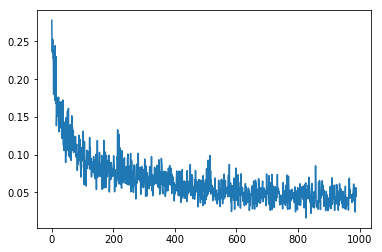

In [43]:
all_losses = [arr[0] for arr in model.train_history[10:]]
plt.figure()
plt.plot(all_losses)